In [1]:
import pickle
from pathlib import Path
from skimage import io

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import keras

import tensorflow as tf

from keras.models import Sequential

from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

In [2]:
labels = pd.read_csv('datasets/labels.csv', index_col=0)

print(labels.genus.value_counts())

y = labels.genus.values

print(labels.shape)

0.0    827
1.0    827
Name: genus, dtype: int64
(1654, 1)


Example image has shape:  (50, 50, 3)
RGB values for the top left pixel are: [127 108  95]


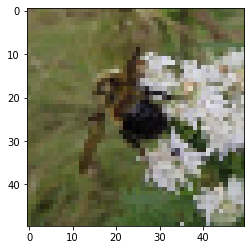

In [3]:
example_image = io.imread('datasets/{}.jpg'.format(labels.index[0]))

plt.imshow(example_image)

print('Example image has shape: ', example_image.shape)
                    
print('RGB values for the top left pixel are:', example_image[0, 0, :])

In [4]:
ss = StandardScaler()

image_list = []
for i in labels.index:
    
    img = io.imread('datasets/{}.jpg'.format(i)).astype(np.float64)
    
    # for each channel, applying standard scaler's fit_transform method
    for channel in range(img.shape[2]):
        img[:, :, channel] = ss.fit_transform(img[:, :, channel])
        
    
    image_list.append(img)
    
X = np.array(image_list)

print(X.shape)

(1654, 50, 50, 3)


In [5]:
x_interim, x_eval, y_interim, y_eval = train_test_split(X, y, test_size=0.2, random_state=42)

x_train, x_test, y_train, y_test = train_test_split(x_interim,y_interim, test_size=0.4, random_state=42)
                                           
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print(x_eval.shape[0], 'eval samples')

x_train shape: (793, 50, 50, 3)
793 train samples
530 test samples
331 eval samples


In [6]:
num_classes = 1

model = Sequential()

# first convolutional layer with 32 filters
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(50, 50, 3)))

# add a second 2D convolutional layer with 64 filters
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))

In [7]:
# reducing dimensionality through max pooling
model.add(MaxPooling2D(pool_size=(2, 2)))

# third convolutional layer with 64 filters
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))

# to prevent over fitting
model.add(Dropout(0.25))

# necessary flatten step preceeding dense layer
model.add(Flatten())

# fully connected layer
model.add(Dense(128, activation='relu'))

# add additional dropout to prevent overfitting
model.add(Dropout(0.5))

# prediction layers
model.add(Dense(num_classes, activation='sigmoid', name='preds'))

# show model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 46, 46, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 64)        36928     
_________________________________________________________________
dropout (Dropout)            (None, 21, 21, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 28224)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               3

In [8]:
# model.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.SGD(lr=0.001), metrics=['accuracy'])

# # my_callbacks = [
# #     tf.keras.callbacks.EarlyStopping(patience=2),
# #     tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{accuracy:.2f}.h5'),
# #     tf.keras.callbacks.TensorBoard(log_dir='./logs'),
# # ]

# model.fit(x_train[:793,:,:,:],y_train[:793],epochs=200,verbose=1,validation_data=(x_test[:530, :, :, :], y_test[:530]))
    
   
    
    
    

In [9]:
model = keras.models.load_model('trained_model.h5')

In [10]:
model.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.SGD(lr=0.001), metrics=['accuracy'])

In [11]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test set, loss:', score[0])
print('Test set, accuracy:', score[1])

print("")

eval_score = model.evaluate(x_eval, y_eval, verbose=0)

print('Evaluation set, loss:', eval_score[0])
print('Evaluation set, accuracy:', eval_score[1])

Test set, loss: 0.59632807970047
Test set, accuracy: 0.7245283126831055

Evaluation set, loss: 0.5893811583518982
Evaluation set, accuracy: 0.6918429136276245


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


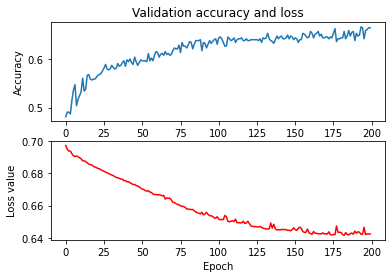

In [12]:
# load history
with open('model_history.pkl', 'rb') as f:
    trained_cnn_history = pickle.load(f)

# print keys for pretrained_cnn_history dict
print(trained_cnn_history.keys())

fig = plt.figure(1)
plt.subplot(211)
# plot the validation accuracy
plt.plot(trained_cnn_history['val_acc'])
plt.title('Validation accuracy and loss')
plt.ylabel('Accuracy')
plt.subplot(212)
# plot the validation loss
plt.plot(trained_cnn_history['val_loss'], 'r')
plt.xlabel('Epoch')
plt.ylabel('Loss value');